<class 'bytes'>
Tensor("ExpandDims_1:0", shape=(1, 224, 224, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from /mnt/workspace/models/checkpoints/vgg_16.ckpt


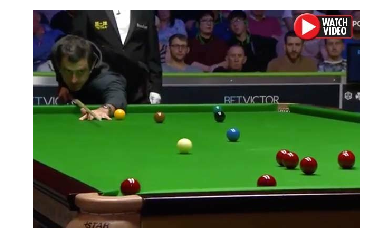

Probability 100.00% => [pool table, billiard table, snooker table]
Probability 0.00% => [croquet ball]
Probability 0.00% => [ping-pong ball]
Probability 0.00% => [tennis ball]
Probability 0.00% => [racket, racquet]


In [3]:
from os import sys
slim_dir = "/mnt/workspace/models/research/slim/"
sys.path.insert(0, slim_dir)
checkpoints_dir = "/mnt/workspace/models/checkpoints/"
from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf

try:
    import urllib2
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

from tensorflow.contrib import slim

means = [123.68, 116.779, 103.939]

image_size = vgg.vgg_16.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/d/d9/First_Student_IC_school_bus_202076.jpg'
    url = "https://cdn.images.dailystar.co.uk/dynamic/63/photos/425000/620x/Ronnie-O-Sullivan-742226.jpg"
    image_string = urllib.urlopen(url).read()
    print(type(image_string))
    
#     filename_queue = tf.train.string_input_producer(['/mnt/workspace/ebrnn-tf/download 1.png']) #  list of files to read
#     reader = tf.WholeFileReader()
#     key, image_string = reader.read(filename_queue)

# #     img = plt.imread('/mnt/workspace/datasets/ucf101/ucf24/rgb-images/GolfSwing/v_GolfSwing_g01_c01/00001.jpg')
# #     img = plt.imread('/mnt/workspace/datasets/ucf101/ucf24/rgb-images/GolfSwing/v_GolfSwing_g01_c01/00001.jpg')
#     img = plt.imread('./snooker.jpg')
#     print(np.shape(img))
# #     plt.imshow(img[:,:,:3])
#     image = tf.convert_to_tensor(img[:,:,:3], dtype=tf.uint8)
#     processed_images1  = tf.expand_dims(image, 0)
#     print(image)
#     normalized_images1 = tf.image.resize_images(processed_images1, [image_size,image_size])
#     print(normalized_images1)
#     channels = tf.split(axis=3, num_or_size_splits=3, value=normalized_images1)
#     for j in range(3):
#         channels[j] -= means[j]
#     processed_images = tf.concat(axis=3, values=channels)
    
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = vgg_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    print(processed_images)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        # 1000 classes instead of 1001.
        logits, _ = vgg.vgg_16(processed_images, num_classes=1000, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()
    
    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Shift the index of a class name by one. 
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index+1]))